# Individual Analysis for the H-D Spectrum Experiment

In [1]:
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as up
import matplotlib.pyplot as plt
import pandas as pd
from lmfit.models import ConstantModel, GaussianModel
from lmfit.models import LinearModel
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
%matplotlib inline

In [2]:
Na = pd.read_csv('Na_D_lines_run1.CSV',skiprows=15)

In [3]:
Na[:10]

,TIME,CH1,CH1 Peak Detect
0,-20.000,-0.020,-0.012
1,-19.992,-0.012,-0.028
2,-19.985,-0.020,-0.012
3,-19.977,-0.020,-0.028
4,-19.969,-0.020,-0.012
5,-19.962,-0.020,-0.028
6,-19.954,-0.020,-0.012
7,-19.946,-0.020,-0.028
8,-19.939,-0.020,-0.004
9,-19.931,-0.020,-0.028


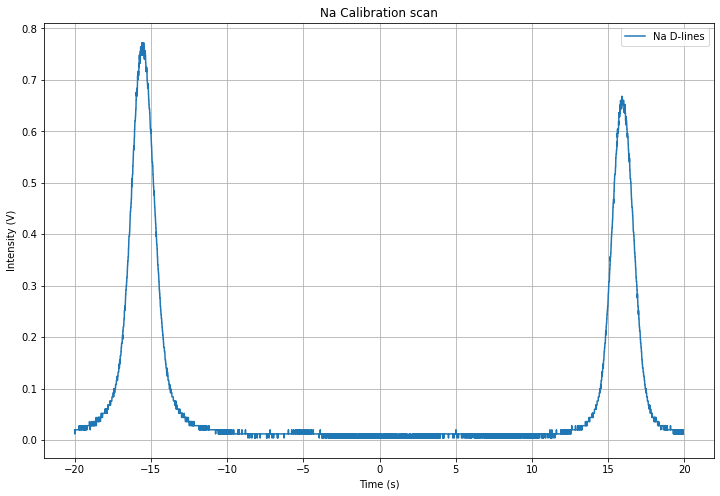

In [4]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Time (s)')
plt.plot(Na['TIME'],-Na['CH1'],'-',label='Na D-lines')
plt.legend();

In [6]:
Na['CH1_smoothed'] = gaussian_filter1d(Na['CH1'], 5)

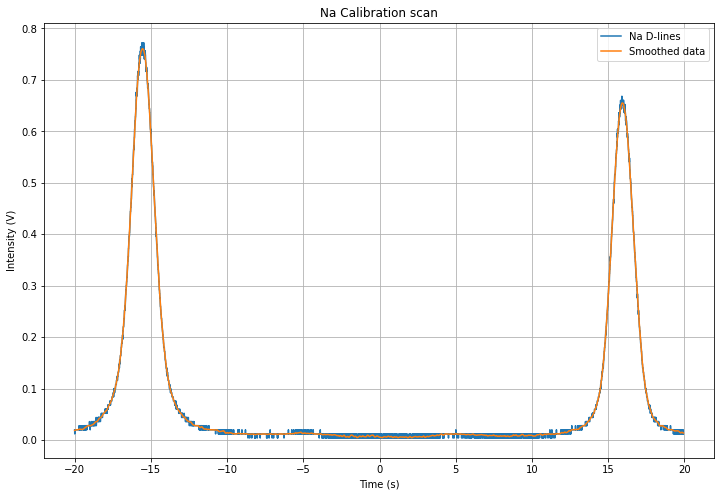

In [7]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Time (s)')
plt.plot(Na['TIME'],-Na['CH1'],'-',label='Na D-lines')
plt.plot(Na['TIME'],-Na['CH1_smoothed'],'-',label='Smoothed data')
plt.legend();

In [8]:
ydata = -Na['CH1_smoothed']
xdata = Na['TIME']

min_width = 50

peaks, pk_props = find_peaks(ydata, width = min_width, height = ydata.max()/2.)

for pk, prop in zip(peaks, pk_props['widths']): 
    print('Peak at {:d} has width {:.1f}'.format(pk, prop))


Peak at 579 has width 234.6
Peak at 4678 has width 220.6


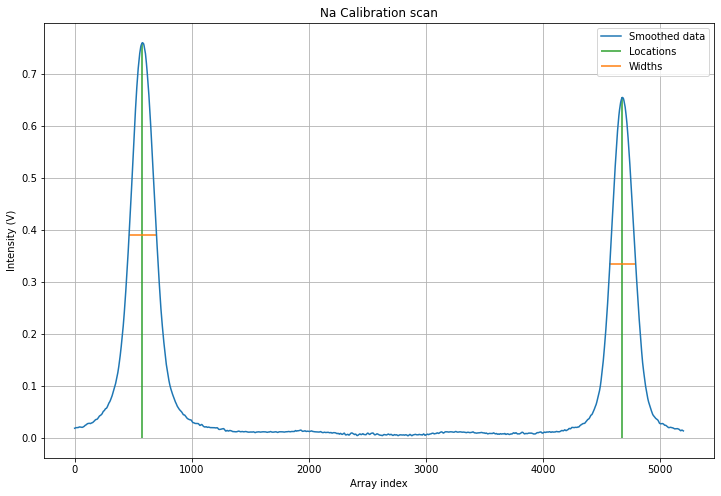

In [9]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Array index')
plt.plot(ydata,'-',label='Smoothed data')
plt.vlines(x=peaks, ymin=0, ymax=ydata[peaks], color='C2', label='Locations')
plt.hlines(y=pk_props['width_heights'], xmin=peaks-pk_props['widths']/2, 
           xmax=peaks+pk_props['widths']/2, color = 'C1', label='Widths')
plt.legend();

In [10]:
xpeaks = np.array([xdata[peaks[0]], xdata[peaks[1]]])
xpeaks

array([-15.553,  15.929])

In [11]:
idx2time = (xdata[peaks[1]]-xdata[peaks[0]])/(peaks[1]-peaks[0])
xwidths = pk_props['widths']*idx2time
xwidths

array([1.80154935, 1.69445696])

In [12]:
Cal_data = np.array([
    [643.85, 41.43],
    [579.07, 37.24],
    [576.96, 37.11],
    [546.08, 35.10],
    [508.58, 32.68],
    [479.99, 30.83],
    [467.81, 30.04],
    [435.83, 27.96],
    [404.66, 25.98]])

wavelength = Cal_data[:,0]
position = Cal_data[:,1]

[643.85 579.07 576.96 546.08 508.58 479.99 467.81 435.83 404.66]


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 9
    # variables        = 2
    chi-square         = 0.18041902
    reduced chi-square = 0.02577415
    Akaike info crit   = -31.1872805
    Bayesian info crit = -30.7928313
[[Variables]]
    slope:      15.4639413 +/- 0.01139807 (0.07%) (init = 15.46394)
    intercept:  3.20598011 +/- 0.38164201 (11.90%) (init = 3.20598)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.990

Slope =  15.463941344548298 +/- 0.01139806675222934


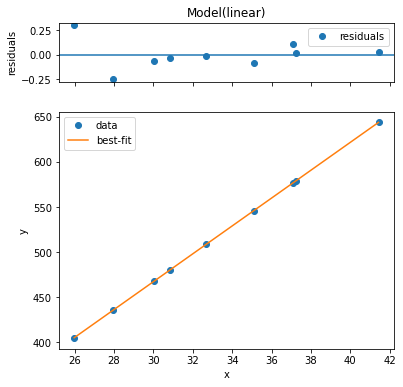

In [13]:
line = LinearModel()
param_guess = line.guess(wavelength, x=position)
line_fit = line.fit(wavelength, param_guess, x=position)

print(line_fit.fit_report())
print('\nSlope = ',line_fit.params['slope'].value,'+/-',line_fit.params['slope'].stderr)

line_fit.plot();

In [14]:
model = ConstantModel() + GaussianModel(prefix='p1_') + GaussianModel(prefix='p2_')

params = model.make_params()

print('parameter names: {}'.format(model.param_names))

parameter names: ['c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma']


In [15]:
p1_loc = xpeaks[0]
p1_sig = xwidths[0]/2.3548
p1_amp = ydata[peaks[0]]*xwidths[0]

p2_loc = xpeaks[1]
p2_sig = xwidths[1]/2.3548
p2_amp = ydata[peaks[1]]*xwidths[0]

params['p1_center'].set(value=p1_loc, vary=True)
params['p1_amplitude'].set(value=p1_amp, vary=True)
params['p1_sigma'].set(value=p1_sig, vary=True)

params['p2_center'].set(value=p2_loc, vary=True)
params['p2_amplitude'].set(value=p2_amp, vary=True)
params['p2_sigma'].set(value=p2_sig, vary=True)

params['c'].set(value = 0.01, vary=True)

params.pretty_print(columns=['value','vary'])

Name             Value     Vary
c                 0.01     True
p1_amplitude      1.37     True
p1_center       -15.55     True
p1_fwhm          1.802    False
p1_height       0.7143    False
p1_sigma        0.7651     True
p2_amplitude      1.18     True
p2_center        15.93     True
p2_fwhm          1.694    False
p2_height       0.6542    False
p2_sigma        0.7196     True


[[Model]]
    ((Model(constant) + Model(gaussian, prefix='p1_')) + Model(gaussian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 5200
    # variables        = 7
    chi-square         = 0.58362586
    reduced chi-square = 1.1239e-04
    Akaike info crit   = -47279.5271
    Bayesian info crit = -47233.6322
[[Variables]]
    c:             0.01563261 +/- 1.6495e-04 (1.06%) (init = 0.01)
    p1_amplitude:  1.48072792 +/- 0.00205703 (0.14%) (init = 1.369798)
    p1_center:    -15.5335294 +/- 0.00122136 (0.01%) (init = -15.553)
    p1_sigma:      0.81152896 +/- 0.00124875 (0.15%) (init = 0.7650541)
    p2_amplitude:  1.16325673 +/- 0.00194365 (0.17%) (init = 1.180005)
    p2_center:     15.9535341 +/- 0.00133464 (0.01%) (init = 15.929)
    p2_sigma:      0.73301773 +/- 0.00136170 (0.19%) (init = 0.7195757)
    p1_fwhm:       1.91100462 +/- 0.00294057 (0.15%) == '2.3548200*p1_sigma'
    p1_height:     0.72791611 +/- 9.

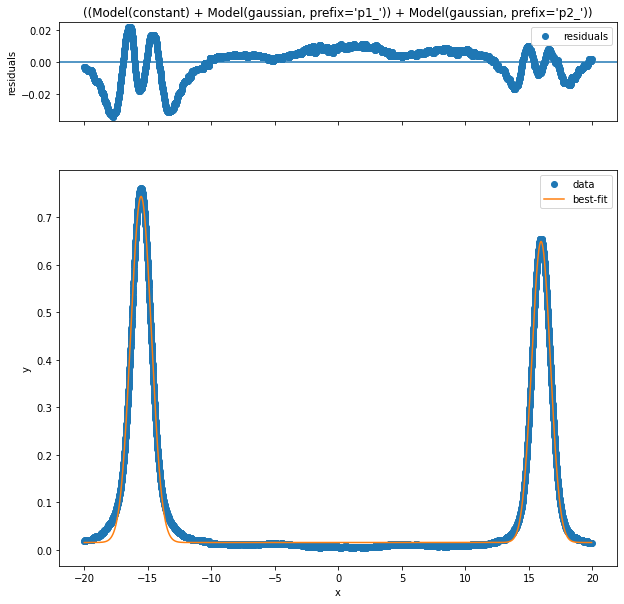

In [16]:
model_fit = model.fit(ydata, params, x=xdata)

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

In [17]:
Peak_loc = []

for parm in model_fit.params:
    if parm.endswith('center'):
        this_center = unc.ufloat(model_fit.params[parm].value, model_fit.params[parm].stderr)
        Peak_loc.append(this_center)
        print('Peak at {:.2uP} s'.format(this_center))

Na_loc = Peak_loc.copy()

Peak at -15.5335±0.0012 s
Peak at 15.9535±0.0013 s


In [18]:
D1 = 5895.92 # Angstroms
D2 = 5889.95 # Angstroms

Na_cal = (D1-D2)/(Na_loc[1]-Na_loc[0])
Na_bad = (D1-D2)/(Na_loc[1]-Na_loc[0] + 2)

print('Calibration constant from peak-fit method: {:.2uP} A/s'.format(Na_cal))
print('Bad Calibration constant from peak-fit method: {:.2uP} A/s'.format(Na_bad))

diff = Na_cal - Na_bad
print(diff)

Calibration constant from peak-fit method: 0.189602±0.000011 A/s
Bad Calibration constant from peak-fit method: 0.1782778±0.0000096 A/s
0.0113239+/-0.0000013


In [19]:
Alpha = pd.read_csv('HD_Alpha_run1.CSV',skiprows=15)
Beta = pd.read_csv('HD_Beta_run1.CSV',skiprows=15)
Delta = pd.read_csv('HD_Delta_run1.CSV',skiprows=15)
Gamma = pd.read_csv('HD_Gamma_run1.CSV',skiprows=15)
Eps1 = pd.read_csv('HD-Epsilon_run1.CSV',skiprows=15)
Eps2 = pd.read_csv('HD-Epsilon_run2.CSV',skiprows=15)

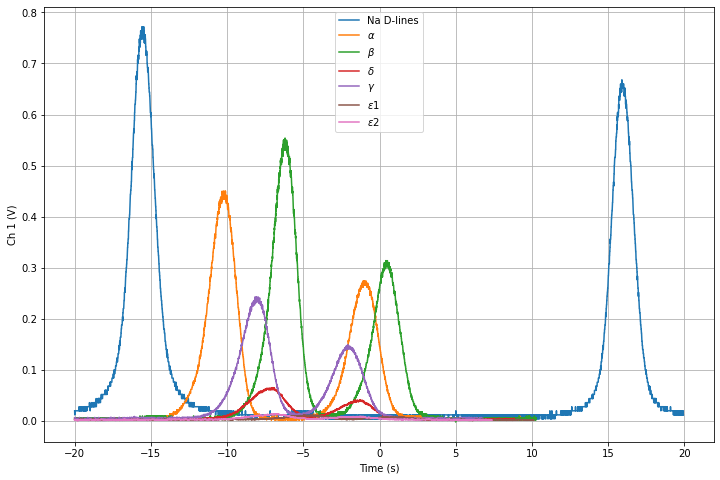

In [20]:
plt.figure(figsize=(12,8))
plt.plot(Na['TIME'],-Na['CH1'],'-',label='Na D-lines')
plt.plot(Alpha['TIME'],-Alpha['CH1'],'-',label=r'$\alpha$')
plt.plot(Beta['TIME'],-Beta['CH1'],'-',label=r'$\beta$')
plt.plot(Delta['TIME'],-Delta['CH1'],'-',label=r'$\delta$')
plt.plot(Gamma['TIME'],-Gamma['CH1'],'-',label=r'$\gamma$')
plt.plot(Eps1['TIME'],-Eps1['CH1'],'-',label=r'$\epsilon$1')
plt.plot(Eps2['TIME'],-Eps2['CH1'],'-',label=r'$\epsilon$2')

plt.xlabel(r'Time (s)')
plt.ylabel(r'Ch 1 (V)')
plt.legend()
plt.grid();

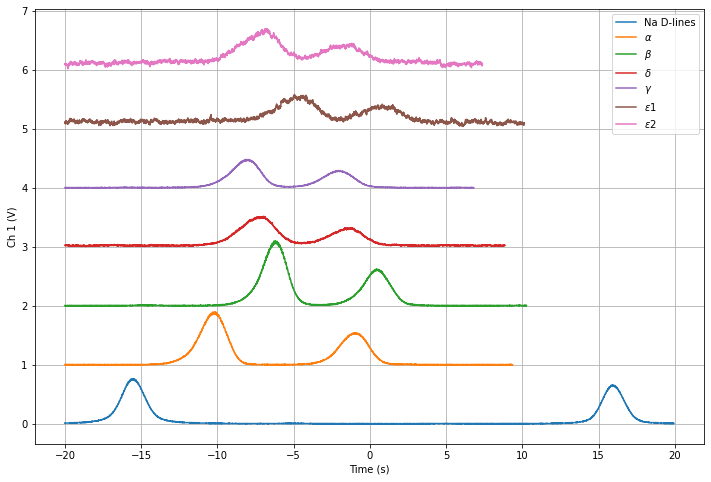

In [21]:
plt.figure(figsize=(12,8))
plt.plot(Na['TIME'],-Na['CH1'],'-',label='Na D-lines')
plt.plot(Alpha['TIME'],-Alpha['CH1']*2+1,'-',label=r'$\alpha$')
plt.plot(Beta['TIME'],-Beta['CH1']*2+2,'-',label=r'$\beta$')
plt.plot(Delta['TIME'],-Delta['CH1']*8+3,'-',label=r'$\delta$')
plt.plot(Gamma['TIME'],-Gamma['CH1']*2+4,'-',label=r'$\gamma$')
plt.plot(Eps1['TIME'],-Eps1['CH1']*50+5,'-',label=r'$\epsilon$1')
plt.plot(Eps2['TIME'],-Eps2['CH1']*50+6,'-',label=r'$\epsilon$2')

plt.xlabel(r'Time (s)')
plt.ylabel(r'Ch 1 (V)')
plt.legend()
plt.grid();

In [22]:
def find_and_plot_peaks(ydata, title='Data', makeplot=True):
    min_width = 50
    peaks, pk_props = find_peaks(ydata, width = min_width, height = ydata.max()/2.)
    for pk, prop in zip(peaks, pk_props['widths']):
        print('Peak at {:d} has width {:.1f}'.format(pk, prop))
    plt.figure(figsize=(12,8))
    plt.grid()
    plt.title(title)
    plt.ylabel(r'Intensity (V)')
    plt.xlabel(r'Array index')
    plt.plot(ydata,'-',label='Smoothed data')
    plt.vlines(x=peaks, ymin=0, ymax=ydata[peaks], color='C2', label='Locations')
    plt.hlines(y=pk_props['width_heights'], xmin=peaks-pk_props['widths']/2, 
           xmax=peaks+pk_props['widths']/2, color = 'C1', label='Widths')
    plt.legend();
    
    return peaks, pk_props['widths']


In [23]:
def guess_start_parms(xdata, ydata, peaks, widths, params):
    xpeaks = np.array([xdata[peaks[0]], xdata[peaks[1]]])
    idx2time = (xdata[peaks[1]]-xdata[peaks[0]])/(peaks[1]-peaks[0])
    xwidths = pk_props['widths']*idx2time
    
    model = ConstantModel() + GaussianModel(prefix='p1_') + GaussianModel(prefix='p2_')

    params = model.make_params()

    p1_loc = xpeaks[0]
    p1_sig = xwidths[0]/2.3548
    p1_amp = ydata[peaks[0]]*xwidths[0]

    p2_loc = xpeaks[1]
    p2_sig = xwidths[1]/2.3548
    p2_amp = ydata[peaks[1]]*xwidths[0]

    params['p1_center'].set(value=p1_loc, vary=True)
    params['p1_amplitude'].set(value=p1_amp, vary=True)
    params['p1_sigma'].set(value=p1_sig, vary=True)

    params['p2_center'].set(value=p2_loc, vary=True)
    params['p2_amplitude'].set(value=p2_amp, vary=True)
    params['p2_sigma'].set(value=p2_sig, vary=True)

    params['c'].set(value = 0.01, vary=True)

    params.pretty_print(columns=['value','vary'])
    
    return params


In [24]:
def calculate_peak_locs(xdata, ydata, params):
    model_fit = model.fit(ydata, params, x=xdata)
    
    Peak_loc = []

    for parm in model_fit.params:
        if parm.endswith('center'):
            this_center = unc.ufloat(model_fit.params[parm].value, model_fit.params[parm].stderr)
            Peak_loc.append(this_center)
            print('Peak at {:.2uP} s'.format(this_center))
            
    return Peak_loc


Peak at 579 has width 234.6
Peak at 4678 has width 220.6
Name             Value     Vary
c                 0.01     True
p1_amplitude      1.37     True
p1_center       -15.55     True
p1_fwhm          1.802    False
p1_height       0.7143    False
p1_sigma        0.7651     True
p2_amplitude      1.18     True
p2_center        15.93     True
p2_fwhm          1.694    False
p2_height       0.6542    False
p2_sigma        0.7196     True
Peak at -15.5335±0.0012 s
Peak at 15.9535±0.0013 s


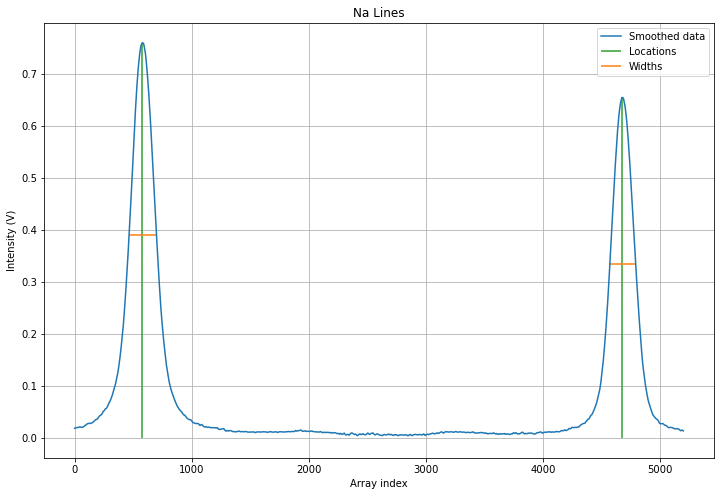

In [25]:
Na_pks, Na_widths = find_and_plot_peaks(ydata, title='Na Lines', makeplot=True)
Na_start_params = guess_start_parms(xdata, ydata, Na_pks, Na_widths, params)
Na_test_loc = calculate_peak_locs(xdata, ydata, Na_start_params)

Peak at 1274 has width 266.7
Peak at 2480 has width 285.6


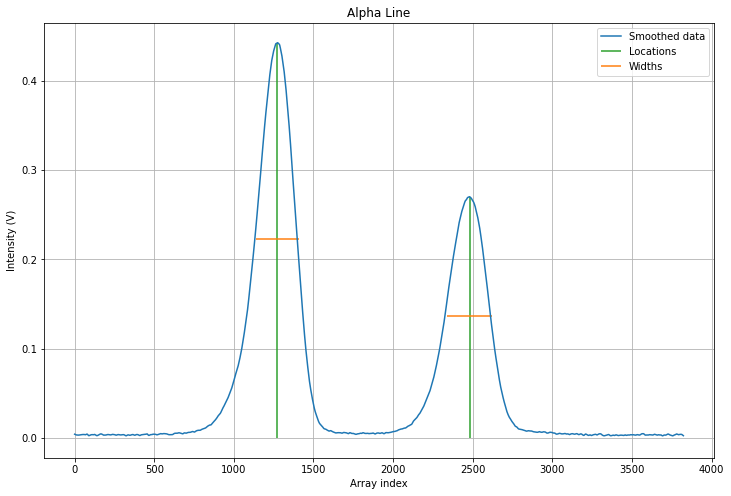

In [26]:
Alpha['CH1_smoothed'] = gaussian_filter1d(Alpha['CH1'], 5)

xdata = Alpha['TIME']
ydata = -Alpha['CH1_smoothed']

peaks, widths = find_and_plot_peaks(ydata, title='Alpha Line', makeplot=True)

In [27]:
start_params = guess_start_parms(xdata, ydata, peaks, widths, params)

Alpha_loc = calculate_peak_locs(xdata, ydata, start_params)

Name             Value     Vary
c                 0.01     True
p1_amplitude    0.7972     True
p1_center       -10.21     True
p1_fwhm          1.802    False
p1_height       0.4157    False
p1_sigma        0.7651     True
p2_amplitude    0.4865     True
p2_center      -0.9524     True
p2_fwhm          1.694    False
p2_height       0.2697    False
p2_sigma        0.7196     True
Peak at -10.3002±0.0015 s
Peak at -1.0429±0.0025 s


Peak at 1798 has width 241.0
Peak at 2670 has width 257.6


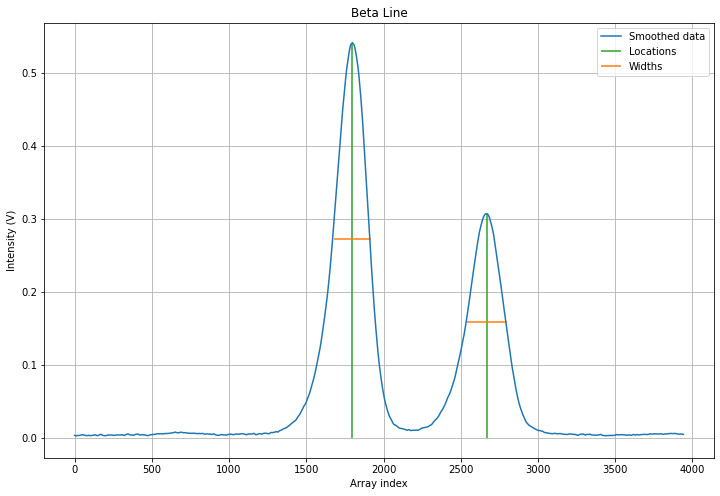

In [28]:
Beta['CH1_smoothed'] = gaussian_filter1d(Beta['CH1'], 5)

xdata = Beta['TIME']
ydata = -Beta['CH1_smoothed']

peaks, widths = find_and_plot_peaks(ydata, title='Beta Line', makeplot=True)

In [29]:
start_params = guess_start_parms(xdata, ydata, peaks, widths, params)
Beta_loc = calculate_peak_locs(xdata, ydata, start_params)

Name             Value     Vary
c                 0.01     True
p1_amplitude    0.9762     True
p1_center       -6.191     True
p1_fwhm          1.802    False
p1_height        0.509    False
p1_sigma        0.7651     True
p2_amplitude    0.5538     True
p2_center       0.5069     True
p2_fwhm          1.694    False
p2_height       0.3071    False
p2_sigma        0.7196     True
Peak at -6.2606±0.0015 s
Peak at 0.4289±0.0028 s


Peak at 1564 has width 286.8
Peak at 2334 has width 294.2


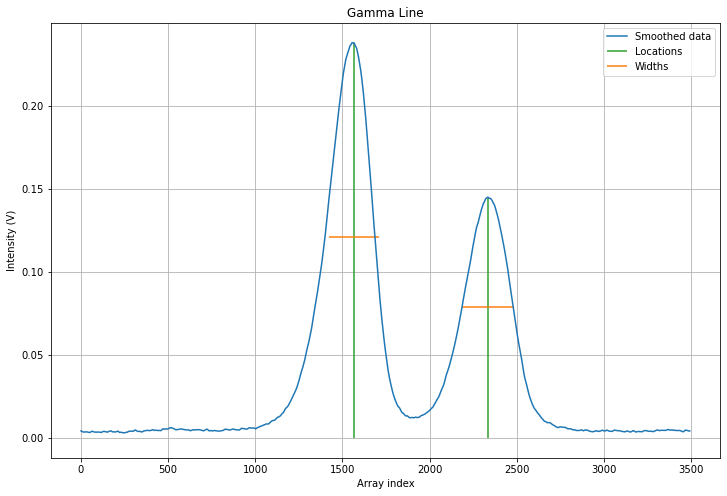

In [30]:
Gamma['CH1_smoothed'] = gaussian_filter1d(Gamma['CH1'], 5)

xdata = Gamma['TIME']
ydata = -Gamma['CH1_smoothed']

peaks, widths = find_and_plot_peaks(ydata, title='Gamma Line', makeplot=True)

In [31]:
start_params = guess_start_parms(xdata, ydata, peaks, widths, params)

Gamma_loc = calculate_peak_locs(xdata, ydata, start_params)

Name             Value     Vary
c                 0.01     True
p1_amplitude    0.4286     True
p1_center       -7.988     True
p1_fwhm          1.802    False
p1_height       0.2235    False
p1_sigma        0.7651     True
p2_amplitude    0.2612     True
p2_center       -2.074     True
p2_fwhm          1.694    False
p2_height       0.1448    False
p2_sigma        0.7196     True
Peak at -8.1607±0.0019 s
Peak at -2.0989±0.0032 s


Peak at 1692 has width 361.6
Peak at 2439 has width 290.8


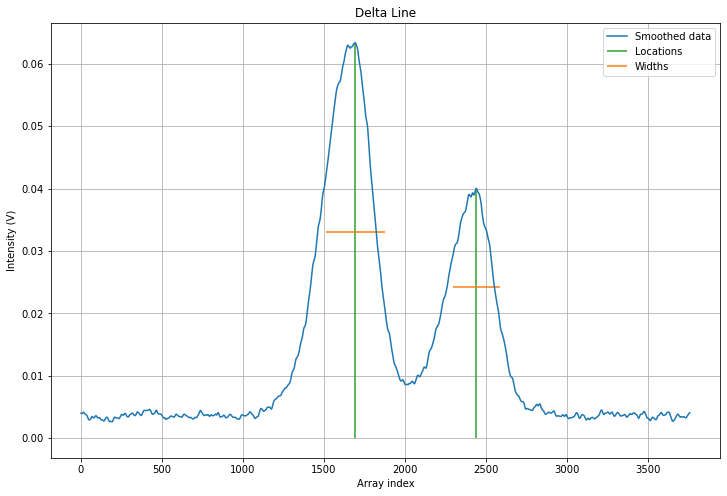

In [32]:
Delta['CH1_smoothed'] = gaussian_filter1d(Delta['CH1'], 5)

xdata = Delta['TIME']
ydata = -Delta['CH1_smoothed']

peaks, widths = find_and_plot_peaks(ydata, title='Delta Line', makeplot=True)

In [33]:
start_params = guess_start_parms(xdata, ydata, peaks, widths, params)

Delta_loc = calculate_peak_locs(xdata, ydata, start_params)

Name             Value     Vary
c                 0.01     True
p1_amplitude    0.1142     True
p1_center       -7.005     True
p1_fwhm          1.802    False
p1_height      0.05955    False
p1_sigma        0.7651     True
p2_amplitude   0.07211     True
p2_center       -1.267     True
p2_fwhm          1.694    False
p2_height      0.03998    False
p2_sigma        0.7196     True
Peak at -7.3535±0.0019 s
Peak at -1.5491±0.0031 s


Peak at 1961 has width 392.0
Peak at 2711 has width 341.2


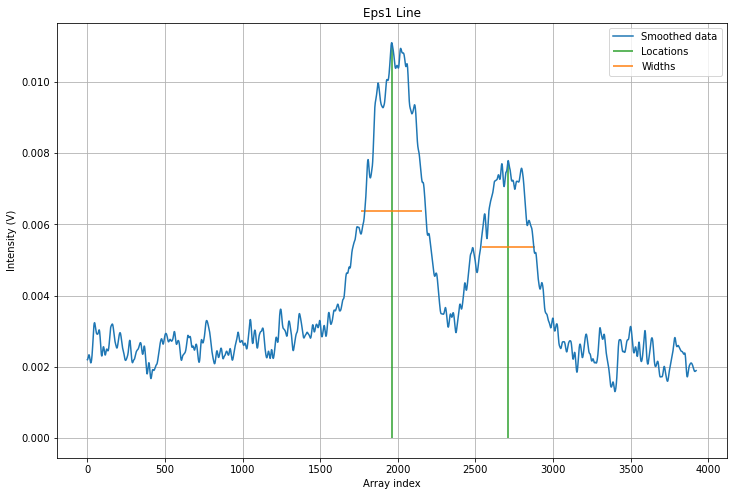

In [34]:
Eps1['CH1_smoothed'] = gaussian_filter1d(Eps1['CH1'], 5)

xdata = Eps1['TIME']
ydata = -Eps1['CH1_smoothed']

peaks, widths = find_and_plot_peaks(ydata, title='Eps1 Line', makeplot=True)

In [35]:
start_params = guess_start_parms(xdata, ydata, peaks, widths, params)

Eps1_loc = calculate_peak_locs(xdata, ydata, start_params)

Name             Value     Vary
c                 0.01     True
p1_amplitude      0.02     True
p1_center       -4.939     True
p1_fwhm          1.802    False
p1_height      0.01043    False
p1_sigma        0.7651     True
p2_amplitude   0.01403     True
p2_center       0.8218     True
p2_fwhm          1.695    False
p2_height      0.00778    False
p2_sigma        0.7196     True
Peak at -4.8256±0.0051 s
Peak at 0.7402±0.0078 s


Peak at 1723 has width 416.3
Peak at 2442 has width 349.4


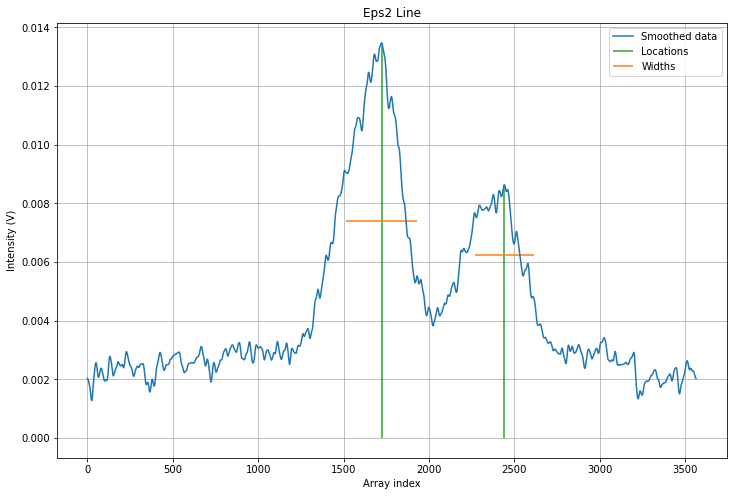

In [36]:
Eps2['CH1_smoothed'] = gaussian_filter1d(Eps2['CH1'], 5)

xdata = Eps2['TIME']
ydata = -Eps2['CH1_smoothed']

peaks, widths = find_and_plot_peaks(ydata, title='Eps2 Line', makeplot=True)

In [37]:
start_params = guess_start_parms(xdata, ydata, peaks, widths, params)

Eps2_loc = calculate_peak_locs(xdata, ydata, start_params)

Name             Value     Vary
c                 0.01     True
p1_amplitude   0.02428     True
p1_center       -6.766     True
p1_fwhm          1.802    False
p1_height      0.01266    False
p1_sigma        0.7651     True
p2_amplitude   0.01555     True
p2_center       -1.244     True
p2_fwhm          1.694    False
p2_height     0.008622    False
p2_sigma        0.7196     True
Peak at -7.1649±0.0048 s
Peak at -1.7404±0.0081 s


In [38]:
D_T = [Alpha_loc[1]-Alpha_loc[0],
      Beta_loc[1]-Beta_loc[0],
      Gamma_loc[1]-Gamma_loc[0],
      Delta_loc[1]-Delta_loc[0],
      Eps1_loc[1]-Eps1_loc[0],
      Eps2_loc[1]-Eps2_loc[0]]
D_T

[9.257328209822651+/-0.002929536044572564,
 6.689559858685684+/-0.0031675131741054565,
 6.061864567290248+/-0.0037386107406596624,
 5.80435181129765+/-0.0036802921195006355,
 5.565883554046021+/-0.009306522561337559,
 5.4245551636850085+/-0.009431270756923633]

In [39]:
Delta_T = pd.Series({'Alpha': Alpha_loc[1]-Alpha_loc[0],
                   'Beta': Beta_loc[1]-Beta_loc[0],
                   'Gamma': Gamma_loc[1]-Gamma_loc[0],
                   'Delta': Delta_loc[1]-Delta_loc[0],
                   'Epsilon': (Eps1_loc[1]+Eps2_loc[1]-Eps1_loc[0]-Eps2_loc[0])/2.0})
Delta_T

Alpha      9.2573+/-0.0029
Beta       6.6896+/-0.0032
Gamma        6.062+/-0.004
Delta        5.804+/-0.004
Epsilon      5.495+/-0.007
dtype: object

In [40]:
lambda_H = pd.Series({'Alpha': 6562.79,
                   'Beta': 4863.33,
                   'Gamma': 4340.46,
                   'Delta': 4101.73,
                   'Epsilon': 3970.07})
lambda_H

Alpha      6562.79
Beta       4863.33
Gamma      4340.46
Delta      4101.73
Epsilon    3970.07
dtype: float64

In [41]:
HD_results = pd.DataFrame({'lambda_H (A)':lambda_H, 'Delta-t (s)': Delta_T})
HD_results

,lambda_H (A),Delta-t (s)
Alpha,6562.79,9.2573+/-0.0029
Beta,4863.33,6.6896+/-0.0032
Gamma,4340.46,6.062+/-0.004
Delta,4101.73,5.804+/-0.004
Epsilon,3970.07,5.495+/-0.007


In [42]:
HD_results['Delta-lambda (A)'] = HD_results['Delta-t (s)']*Na_cal
HD_results['Delta-lambda-bad (A)'] = HD_results['Delta-t (s)']*Na_bad
HD_results

,lambda_H (A),Delta-t (s),Delta-lambda (A),Delta-lambda-bad (A)
Alpha,6562.79,9.2573+/-0.0029,1.7552+/-0.0006,1.6504+/-0.0005
Beta,4863.33,6.6896+/-0.0032,1.2684+/-0.0006,1.1926+/-0.0006
Gamma,4340.46,6.062+/-0.004,1.1493+/-0.0007,1.0807+/-0.0007
Delta,4101.73,5.804+/-0.004,1.1005+/-0.0007,1.0348+/-0.0007
Epsilon,3970.07,5.495+/-0.007,1.0419+/-0.0013,0.9797+/-0.0012


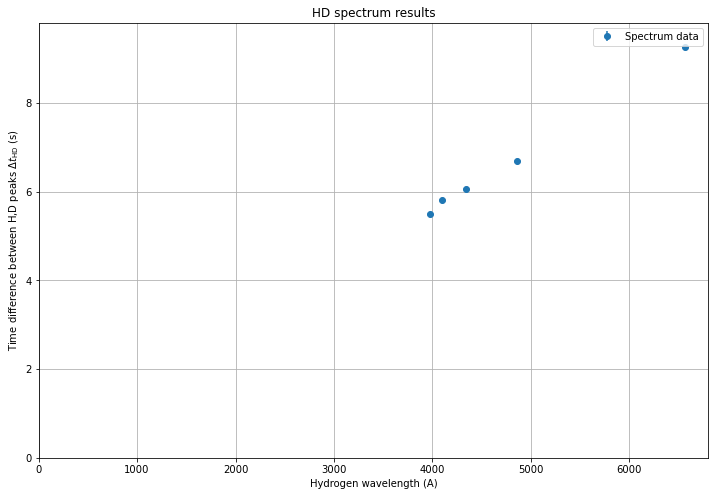

In [43]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('HD spectrum results')
plt.ylim(0,9.8)
plt.xlim(0,6800.0)
plt.ylabel(r'Time difference between H,D peaks $\Delta t_{\rm HD}$ (s)')
plt.xlabel(r'Hydrogen wavelength (A)')
plt.errorbar(HD_results['lambda_H (A)'],up.nominal_values(HD_results['Delta-t (s)']),fmt='o',
             yerr=up.std_devs(HD_results['Delta-t (s)']),label='Spectrum data');
plt.legend();


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 5
    # variables        = 2
    chi-square         = 0.02248479
    reduced chi-square = 0.00749493
    Akaike info crit   = -23.0217698
    Bayesian info crit = -23.8028940
[[Variables]]
    slope:      0.00142858 +/- 4.0839e-05 (2.86%) (init = 15.46394)
    intercept: -0.14936410 +/- 0.19852101 (132.91%) (init = 3.20598)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.981

Slope =  0.0014285846749510743 +/- 4.0839394975009025e-05


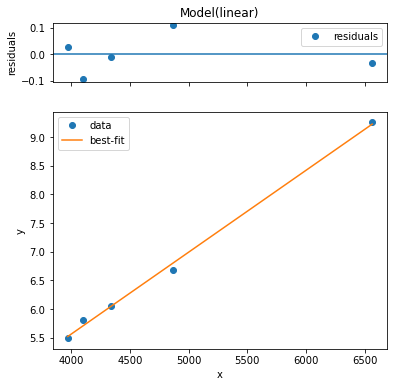

In [44]:
xdata = HD_results['lambda_H (A)']
ydata = up.nominal_values(HD_results['Delta-t (s)'])
yuncert = up.std_devs(HD_results['Delta-t (s)'])

line_fit = line.fit(ydata, param_guess, x=xdata)

print(line_fit.fit_report())

print('\nSlope = ',line_fit.params['slope'].value,'+/-',line_fit.params['slope'].stderr)

line_fit.plot();

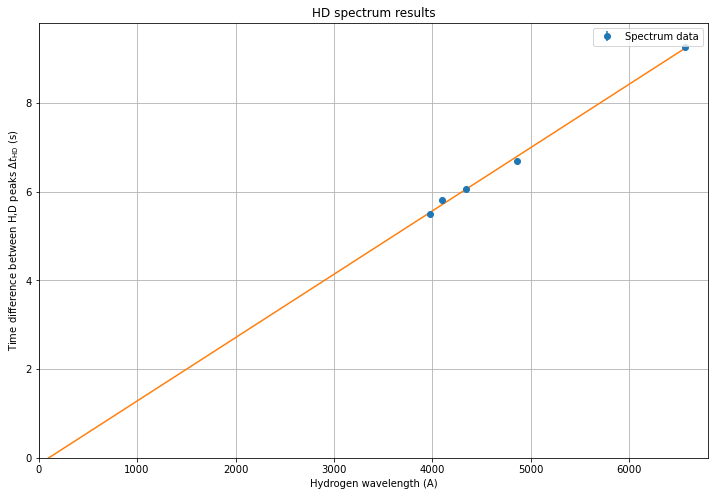

In [45]:
xfit = np.linspace(0,6600,10)
yfit = line_fit.eval(line_fit.params, x=xfit)

plt.figure(figsize=(12,8))
plt.grid()
plt.title('HD spectrum results')
plt.ylim(0,9.8)
plt.xlim(0,6800.0)
plt.ylabel(r'Time difference between H,D peaks $\Delta t_{\rm HD}$ (s)')
plt.xlabel(r'Hydrogen wavelength (A)')
plt.errorbar(HD_results['lambda_H (A)'],up.nominal_values(HD_results['Delta-t (s)']),fmt='o',
             yerr=up.std_devs(HD_results['Delta-t (s)']),label='Spectrum data');
plt.legend();
plt.plot(xfit,yfit);

In [46]:
HD_slope = unc.ufloat(line_fit.params['slope'].value,line_fit.params['slope'].stderr)

mass_ratio = -1*(HD_slope*Na_cal*(1+1836.15)-1)

bad_mass_ratio = -1*(HD_slope*Na_bad*(1+1836.15)-1)

percent_diff = (mass_ratio-bad_mass_ratio)*100/mass_ratio
print('Percent change = {:.2uP}'.format(percent_diff))
print('Calculated Mass ratio of hydrogen/deuterium = {:.2uP}'.format(mass_ratio))
print('Calculated bad Mass ratio of hydrogen/deuterium = {:.2uP}'.format(bad_mass_ratio))

accepted_value = 0.500248
difference = abs(accepted_value - mass_ratio)

print('Difference of given mass ratio and calculated mass ratio = {:.4uP}'.format(difference))

Percent change = -5.92±0.34
Calculated Mass ratio of hydrogen/deuterium = 0.502±0.014
Calculated bad Mass ratio of hydrogen/deuterium = 0.532±0.013
Difference of given mass ratio and calculated mass ratio = 0.00214±0.01423
